**ENHANCING**

**Generating a pandas dataframe from the source .csv file**

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# Set options to show all columns
pd.set_option('display.max_columns', None)

# Load csv file and generate pandas dataframe
input_csv = r'..\data\clean\after_step_1_cleaning_houses.csv' # Fill your path to file
clean_dataset_1 = pd.read_csv(input_csv, sep = ',')

clean_dataset_1.head()

,id,locality_name,Postal_code,Price,Subtype,Number_of_bedrooms,Living_area,street,number,latitude,longitude,Open_fire,Swimming_Pool,hasTerrace,terraceSurface,gardenSurface,Kitchen_type,Number_of_facades,State_of_building,Furnished,epc,landSurface,price_per_sqm,price_per_sqm_land
0,20252354,Ronse,9600,319000,House,3,125,Rotterij,148,50.744176,3.625722,0,0,1,0,370,NaN,4,To renovate,0,F,767,2552.000000,415.906128
1,20251003,Geraardsbergen,9500,299999,House,3,167,Pirrestraat,17,50.752121,3.925495,0,0,1,0,895,Installed,2,Good,0,D,1050,1796.401198,285.713333
2,20252002,Mechelen,2800,275000,House,3,154,Caputsteenstraat,150,51.033269,4.491795,0,0,1,10,20,Semi equipped,2,To renovate,0,E,120,1785.714286,2291.666667
3,20252352,Gooik,1755,295000,House,3,172,Strijlandstraat,45,50.791877,4.084293,0,0,1,0,300,NaN,3,To renovate,0,F,309,1715.116279,954.692557
4,20251715,Dilbeek,1700,715000,House,3,280,Herdebeekstraat 94-94A,0,50.840610,4.228425,0,1,1,36,374,NaN,3,As new,0,C,374,2553.571429,1911.764706


**Adding columns on price per m^2**
- And display of the info of the dataframe at start of analysis

In [ ]:
# Adding new column of price per m2 net habitable surface with safeguard for ZeroDivisionError
clean_dataset_1['price_per_sqm'] = np.where(clean_dataset_1['Living_area'] == 0, np.nan, clean_dataset_1['Price'] / clean_dataset_1['Living_area'])

# Adding new column of price per m2 land surface with safeguard for ZeroDivisionError
clean_dataset_1['price_per_sqm_land'] = np.where(clean_dataset_1['landSurface'] == 0, np.nan, clean_dataset_1['Price'] / clean_dataset_1['landSurface'])

# Display info on the dataframe
clean_dataset_1.info()
data_scraped_shape = clean_dataset_1.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9995 entries, 0 to 9994
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  9995 non-null   int64  
 1   locality_name       9995 non-null   object 
 2   Postal_code         9995 non-null   object 
 3   Price               9340 non-null   float64
 4   Subtype             9995 non-null   object 
 5   Number_of_rooms     3328 non-null   float64
 6   Number_of_bedrooms  9356 non-null   float64
 7   Living_area         9170 non-null   float64
 8   sale_annuity        16 non-null     object 
 9   Type_of_sale        9995 non-null   object 
 10  street              9700 non-null   object 
 11  number              9589 non-null   object 
 12  latitude            9705 non-null   float64
 13  longitude           9705 non-null   float64
 14  Open_fire           9995 non-null   bool   
 15  Swimming_Pool       3859 non-null   object 
 16  hasTer

**Categorical Data**

In [10]:
# Getting an idea of the values in columns with dtype 'category'

for col in clean_dataset_1.select_dtypes(include=['category']).columns:
    print(f"Counts for {col}:")
    print(clean_dataset_1[col].value_counts())
    unique_count = clean_dataset_1[col].nunique()
    print("\n")
    print(f"Number of unique entries in {col}: {unique_count}\n")

*Postal code*

In [11]:
# Copy dataframe contents to a new dataframe
clean_dataset_2 = clean_dataset_1.copy()

# Converting the postal codes to dtype 'str'
clean_dataset_2['Postal_code'] = clean_dataset_2['Postal_code'].astype(str)

# Check the missing values
clean_dataset_2['Postal_code'].isnull().mean()*100

# Assess the number of unique postal codes
clean_dataset_2['Postal_code'].value_counts().nunique()

# Dropping a dutch postal code
clean_dataset_2 = clean_dataset_2[clean_dataset_2['Postal_code'] != '4524 JM']

*Postal code - bar graph of top 20*

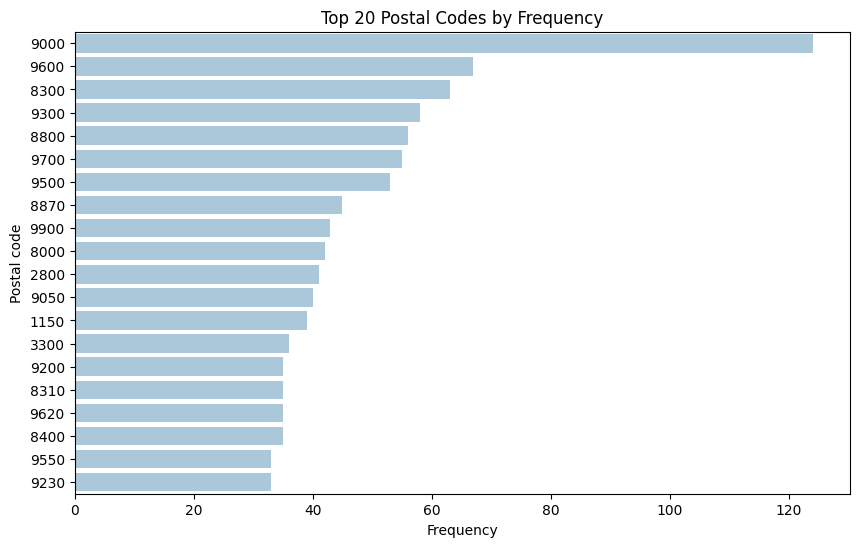

In [12]:
# Checking the postal codes and their counts
frequency = clean_dataset_2['Postal_code'].value_counts()

# Showing the top 20 
top_n = 20 

# Plotting only the top N categories
top_n_categories = frequency.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_n_categories.values, y=top_n_categories.index, color='#A3C9E2')
plt.title(f'Top {top_n} Postal Codes by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Postal code')
plt.show()

*Province - mapping city to a province*

In [13]:
# Copy dataframe contents to a new dataframe
clean_dataset_3 = clean_dataset_2.copy()

# Creating the column province

def get_province(postal_code):
    if postal_code.startswith('1'):
        return 'Brussels' if int(postal_code) < 1300 else 'Brabant_Wallon'
    elif postal_code.startswith('2'):
        return 'Antwerp'
    elif postal_code.startswith('4'):
        return 'Liège'
    elif postal_code.startswith('5'):
        return 'Namur'
    elif postal_code.startswith('6'):
        return 'Luxembourg'
    elif postal_code.startswith('7'):
        return 'Hainaut'
    elif postal_code.startswith('8'):
        return 'West Flanders'
    elif postal_code.startswith('9'):
        return 'East Flanders'
    elif postal_code.startswith('3'):
        return 'Flemish Brabant' if int(postal_code) < 3500 else 'Limburg'
    else:
        return None 

clean_dataset_3['Province'] = clean_dataset_3['Postal_code'].apply(get_province).copy()

# Assigning the dtypes
clean_dataset_3['Province'] = clean_dataset_3['Province'].astype('category')

*Province - bar graph of properties per province*

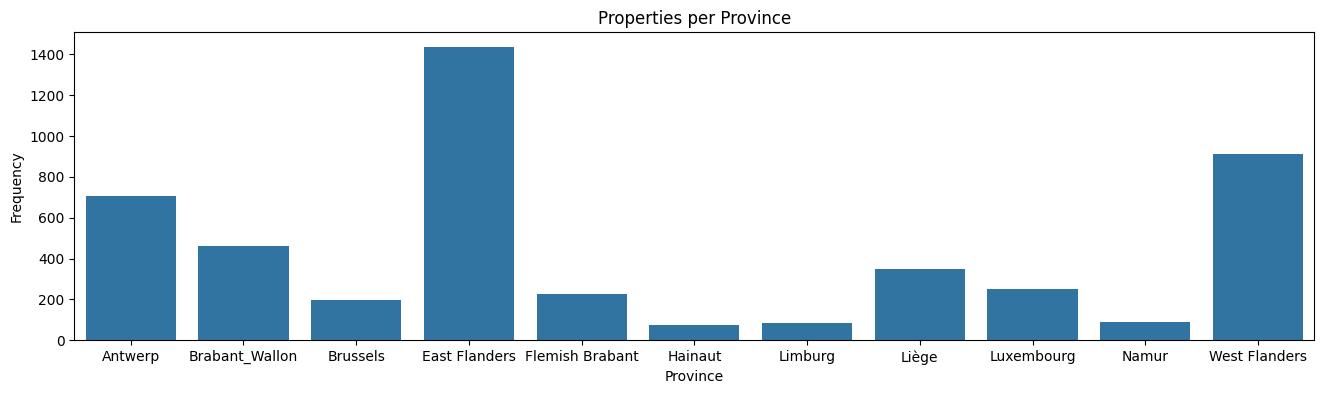

In [14]:
# Checking the amount of properties per province
frequency = clean_dataset_3['Province'].value_counts()

# Plotting the frequency
plt.figure(figsize=(16, 4))
sns.barplot(x=frequency.index, y=frequency.values)
plt.title('Properties per Province')
plt.xlabel('Province')
plt.ylabel('Frequency')
plt.show()

*Proximity of city - generating the data column*

In [15]:
# Creating a column for proximity to the 10 main Belgian cities:
cities_data = {'City': ['Brussels', 'Antwerp', 'Ghent', 'Bruges', 'Liège','Namur', 'Leuven', 'Mons', 'Aalst', 'Sint-Niklaas'],
               'Latitude': [50.8503, 51.2211, 51.0543, 51.2093, 50.6050, 50.4674, 50.8798, 50.4542, 50.9403, 51.1449],
               'Longitude': [4.3517, 4.4120, 3.7174, 3.2240, 5.5797, 4.8712, 4.7033, 3.9514, 4.0364, 4.1525],
               'Radius': [10 for x in range(10)]}

cities_df = pd.DataFrame(cities_data)

cities_df.head(10)

# Make a geodataframe from the cities dataframe
cities_gdf = gpd.GeoDataFrame(cities_df,geometry=gpd.points_from_xy(cities_df.Longitude, cities_df.Latitude))

# Creating the buffer/radius zone (set on 10km)
cities_gdf['buffer'] = cities_gdf.geometry.buffer(cities_gdf['Radius'] / 111)
cities_gdf = cities_gdf.set_geometry('buffer')

cities_gdf.info()

# Checking and slicing original data and creating a new dataframe house_geo
house_geo= pd.DataFrame(clean_dataset_3[['id', 'latitude', 'longitude']]).copy()
#house_geo.info()

# Making a geo dataframe from the dataframe
house_geo_gdf = gpd.GeoDataFrame(house_geo,geometry=gpd.points_from_xy(house_geo.longitude, house_geo.latitude))
#house_geo_gdf.info()

# Join the two gdf geodataframes 'house_geo_gdf' and 'cities_gdf'
joined_gdf = gpd.sjoin(house_geo_gdf, cities_gdf[['City', 'buffer']], how='left', predicate='intersects', lsuffix='_house', rsuffix='_city')
house_geo_gdf['Assigned_City'] = joined_gdf['City']
house_geo_gdf.info()

# Slicing and checking
check_city = house_geo_gdf[house_geo_gdf['Assigned_City'].notna()]
check_city.info()

# Merge the assigned city column to the main dataframe
clean_dataset_3 = pd.merge(clean_dataset_3, house_geo_gdf[['id', 'Assigned_City']], on='id', how='left')



#Make a boolean column of Assigned_City and transform to bool
clean_dataset_3['Has_Assigned_City'] = clean_dataset_3['Assigned_City'].notna()
clean_dataset_3['Has_Assigned_City'] = clean_dataset_3['Has_Assigned_City'].astype('bool')

clean_dataset_3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   City       10 non-null     object  
 1   Latitude   10 non-null     float64 
 2   Longitude  10 non-null     float64 
 3   Radius     10 non-null     int64   
 4   geometry   10 non-null     geometry
 5   buffer     10 non-null     geometry
dtypes: float64(2), geometry(2), int64(1), object(1)
memory usage: 612.0+ bytes
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4789 entries, 0 to 4789
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             4789 non-null   int64   
 1   latitude       4787 non-null   float64 
 2   longitude      4787 non-null   float64 
 3   geometry       4789 non-null   geometry
 4   Assigned_City  1363 non-null   object  
dtypes: float64(2), geometry(1), int64(1), object(1)
memory

**Saving data to a new .csv file and a .pkl file**

In [16]:
# Save data to new csv file

output_csv = r'..\data\clean\after_step_2_enhancing.csv'  # Fill your path to file
clean_dataset_3.to_csv(output_csv, index=False)


# Save data to new pkl file

import pickle
output_pkl = r'..\data\clean\after_step_2_enhancing.pkl' # Fill your path to file
with open(output_pkl, 'wb') as f:
    pickle.dump(clean_dataset_3, f)
